# **EDA + MODELING USING PYSPARK**

Source Dataset : https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

# Install pyspark

In [364]:
pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Memulai Spark SQL Application

Kita perlu meng-import SparkSession sebelum masuk ke Spark SQL Application. **SparkSession** adalah entry point untuk dapat mengakses ke fungsionalitas PySpark seperti untuk membuat PySpark RDD, DataFrame dll.

In [365]:
from pyspark.sql import SparkSession

Untuk membuat aplikasi Spark SQL, dapat dilakukan dengan menggunakan method **.builder()** lalu **.appName** menyesuaikan dengan nama aplikasi spark sql yang akan dijalankan.

In [366]:
spark = SparkSession.builder.appName("diabetes").getOrCreate()

Baca dataset menggunakan method **.read.csv()**

In [367]:
df = spark.read.csv("diabetes.csv", header=True, inferSchema=True)

Menampilkan 5 record data teratas dari dataset dengan method **.show()**

In [368]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



Metode **printSchema()** digunakan untuk menampilkan skema kerangka data PySpark. Method ini akan mengembalikan struktur seperti pohon dan mendapatkan nama kolom serta datetype. 

Dapat dilihat dari hasil skema kerangka data pada dataset ini, terdapat **9 kolom** dengan 2 diantaranya bertipe data **double**, dan sisanya bertipe data **integer**. Lalu, terdapat nilai **nullable = true** yang artinya **tidak ada missing value** pada setiap kolom.

In [369]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



Melihat statistik deskriptif dari dataset menggunakan method **.describe()**

Method **.toPandas()** digunakan untuk mengkonversi spark dataframe ke bentuk pandas dataframe.

Dari hasil statistik deskriptif ini, kita dapat melihat jumlah data pada setiap kolom (**count**), rata-rata setiap kolom (**mean**), standar deviasi (**stddev**), nilai minimun dan maksimun pada setiap kolom (**min**, **max**)

In [370]:
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


Melakukan grouping terhadap kolom 'Outcome' untuk melihat jumlah Outcome yang bernilai 1 dan bernilai 0. Grouping dilakukan dengan menggunakan method **.groupby()**

Outcome bernilai **1** artinya **positif diabetes**, dengan jumlah **268** data.
Outcome bernilai **0** artinya **negatif diabetes**, dengan jumlah **500** data.

In [371]:
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



# Visualisasi Ditribusi Data

Visualisasi distribusi data dilakukan dengan menggunakan library **matplotlib** dan **seaborn**.

In [372]:
import matplotlib.pyplot as plt
import seaborn as sns

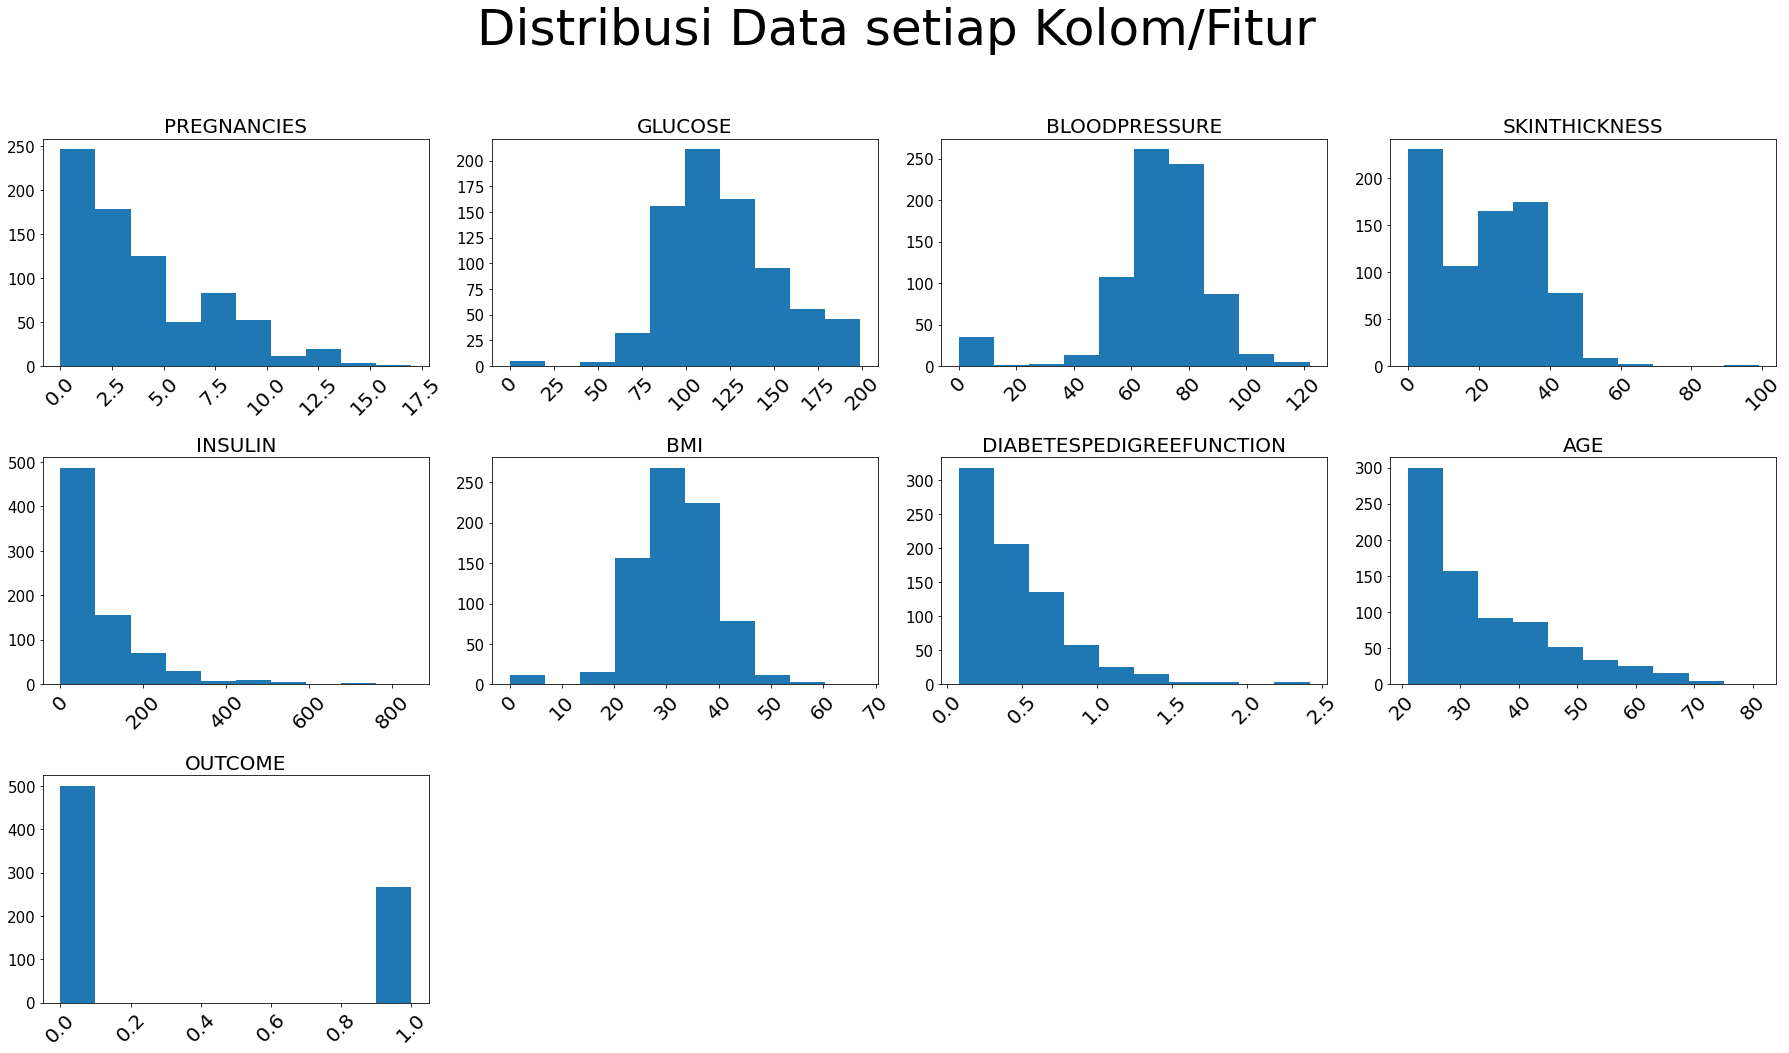

In [373]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribusi Data setiap Kolom/Fitur", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

Dari hasil visualiasi distribusi data diatas, dapat dilihat untuk fitur Pregnancies, Insulin, Diabetespedigreefunction dan Age memiliki visual grafik yang tidak simetris atau dalam statistik biasa disebut dengan Skewness. Lalu, untuk fitur Glucose, Bloodpressure, Skinthickness dan BMI memiliki visual grafik yang dapat dibilang sudah hampir terdistribusi normal, walaupun masih terdapat sedikit outlier di beberapa fitur.

Untuk fitur Outcome termasuk kedalam distribusi binomial.

Mengimport sql function yaitu isnan, when, count dan col untuk digunakan pada method .select(). dimana ini akan mengecek kembali apakah ada missing value di setiap kolom atau tidak.

In [374]:
from pyspark.sql.functions import isnan, when, count, col

In [375]:
# cek missing value
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head() 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


# User Defined Functions (UDF)

UDF digunakan untuk memperluas fungsi dari framework dan menggunakan kembali fungsi tersebut pada beberapa DataFrame. 

Pada PySpark, user membuat fungsi dalam sintaks Python dan membungkusnya dengan PySpark SQL **udf()** atau mendaftarkannya sebagai udf dan menggunakannya masing-masing pada DataFrame dan SQL.

In [376]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

y_udf adalah variabel yang meyimpan nilai yes atau no dengan tipe data string. nantinya variabel ini akan menggantikan kolom Outcome yang bertipe data integer dan bernilai 1 dan 0.

In [377]:
y_udf = udf(lambda y: "no" if y == 0 else "yes", StringType())

Kolom "Outcome" digantikan dengan kolom "HasDiabetes". Kolom "HasDiabetes" ini merupakan user defined function yaitu variabel y_udf yang telah dibuat sebelumnya. 

Sehingga kolom outcome sudah tidak ada lagi, karena digantikan dengan HasDiabetes. Lalu, value dari kolom ini sudah bukan 1 dan 0 lagi, melainkan yes atau no. Ini menunjukkan, jika Yes berarti positif diabetes, dan jika No berarti negatif diabetes. Ini mempermudah dalam pemahaman pembacaan data tabel.

In [378]:
df = df.withColumn("HasDiabetes",y_udf('Outcome')).drop("Outcome")

In [379]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 5 rows



Selanjutnya, yang akan dibuat adalah grouping berdasarkan kolom Age yang ada pada dataset. Seperti yang dapat dilihat pada visualisasi distribusi data sebelumnya, kita mendapatkan hasil distribusi data pada kolom age memiliki ketidaksimetrisan yang konstan, sehingga fitur Age ini yang akan dilakukan grouping dengan mendefinisikan fungsi baru yaitu **udf_multi** sekaligus sebagai fitur yang akan digunakan untuk memprediksi diabetes.

In [380]:
def udf_multi(age):
  if (age < 25):
    return "Dibawah 25 tahun"
  elif (age >=25 and age <= 35):
    return "25 - 35 tahun"
  elif (age >= 36 and age <= 50):
    return "36 - 50 tahun"
  elif (age > 50):
    return "Lebih dari 50 tahun"
  else: return "NA"

Fungsi **udf_multi** lalu dimasukkan ke dalam dataframe dengan nama kolom baru yaitu "**age_udf**", kolom ini mengambil value dari kolom Age.

In [381]:
age_udf = udf(udf_multi)
df = df.withColumn('age_udf', age_udf('Age'))


In [382]:
# hasil dataframe
df.show(10)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|            age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-------------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|      36 - 50 tahun|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|      25 - 35 tahun|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|        yes|      25 - 35 tahun|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|         no|   Dibawah 25 tahun|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|        yes|      25 - 35 tahun|
|       

In [383]:
from pyspark.sql import functions as F 
from pyspark.sql.functions import rank, sum, desc 
from pyspark.sql import Window

In [384]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

Membuat tabel baru dengan meng-select kolom age_udf dan kolom Glucose dan digroup berdasarkan value pada kolom age_udf. 

Pada tabel baru ini, akan dibuat beberapa kolom baru yang diambil berdasarkan perhitungan statistik dari kolom Glucose. Kolom baru tersebut diberi nama alias untuk masing-masing kolomnya sesuai dengan statistik yang berkaitan.

F.Count('Glucose').alias('UserCount') = menghitung jumlah data yang ada pada kolom Glucose berdasarkan age_udf, dan nilai tersebut akan dimasukkan kedalam kolom baru dengan nama alias UserCount yang artinya adalah jumlah orang yang dikategorikan berdasarkan age_udf tersebut.

F.mean('Glucose').alias('Glucose_AVG') = menghitung jumlah rata-rata yang ada pada kolom Glucose berdasarkan age_udf.

F.min('Glucose').alias('Glucose_MIN') = menghitung nilai minimal glukosa yang 
ada pada kolom Glucose berdasarkan age_udf.

F.max('Glucose').alias('Glucose_MAX') = menghitung nilai maksimal glukosa yang ada pada kolom Glucose berdasarkan age_udf.

Lalu, dibuat kolom Percent, yang menyimpan hasil UserCount dikali 100 lalu dibagi kolom total. Setelah itu tabel ini akan di sorting berdasarkan nilai Percent secara descending.

In [385]:
age_group_tab = df.select(["age_udf","Glucose"]).\
                      groupBy('age_udf').\
                          agg(
                              F.count('Glucose').alias('UserCount'),
                              F.mean('Glucose').alias('Glucose_AVG'),
                              F.min('Glucose').alias('Glucose_MIN'),
                              F.max('Glucose').alias('Glucose_MAX')).\
                          withColumn('total', sum(col('UserCount')).over(window)).\
                          withColumn('Percent', col('UserCount')*100 / col('total')).\
                          drop(col('total')).sort(desc('Percent'))

Dihasilkan persentase paling tinggi (Jumlah UserCount) terdapat pada range umur 25-35 tahun.

In [386]:
age_group_tab.toPandas()

,age_udf,UserCount,Glucose_AVG,Glucose_MIN,Glucose_MAX,Percent
0,25 - 35 tahun,279,119.677419,68,198,36.328125
1,Dibawah 25 tahun,219,110.858447,0,199,28.515625
2,36 - 50 tahun,189,126.269841,0,197,24.609375
3,Lebih dari 50 tahun,81,139.679012,57,197,10.546875


Visualisasi dalam bentuk *bar chart*

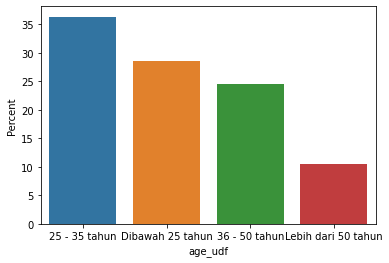

In [387]:
sns.barplot(x="age_udf", y="Percent",data=age_group_tab.toPandas());

Visualisasi dalam bentuk *pie chart*

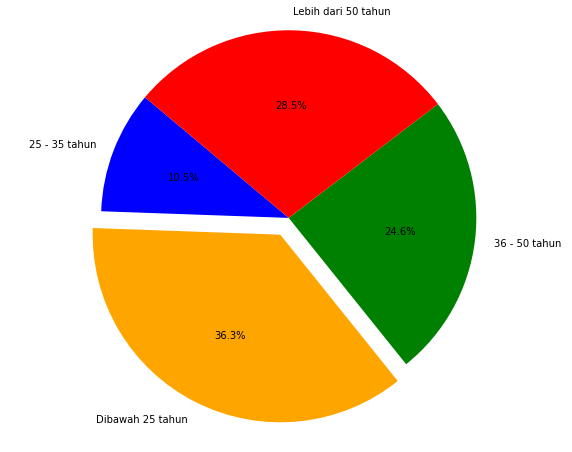

In [388]:
labels = list(age_group_tab.select('age_udf').distinct().toPandas()['age_udf'])
sizes = list(age_group_tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['blue','orange','green','red']
explode = (0.0, 0.1, 0.0, 0.0)

plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=False, startangle=140)
plt.axis('equal')
plt.show()

# Menghitung Korelasi antar Fitur

In [389]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- HasDiabetes: string (nullable = true)
 |-- age_udf: string (nullable = true)



dari output df.printSchema() terdapat 2 fitur yang bertipe data string yaitu HasDiabetes dan age_udf, dikarenakan perhitungan korelasi harus data yang bertipe numerik, maka untuk 2 fitur tersebut tidak akan dilakukan perhitungan korelasi. 

Selanjutnya akan diambil fitur yang tipe datanya hanya numerik.

In [390]:
# ambil hanya yang tipe datanya numerik

numeric_features = [t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [391]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [392]:
from pyspark.mllib.stat import Statistics
import pandas as pd

Menghitung korelasi variabel dengan metode **Pearson Correlation**

In [393]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00


Agar lebih mudah melihat korelasi antar fiturnya, dibuat visualisasi dengan heatmap.

Pada heatmap kita dapat melihat semakin cerah warna berarti semakin tinggi korelasinya. Kolom **Age** dan **Pregnancies** memiliki korelasi yang tinggi dibandingkan dengan yang lainnya.

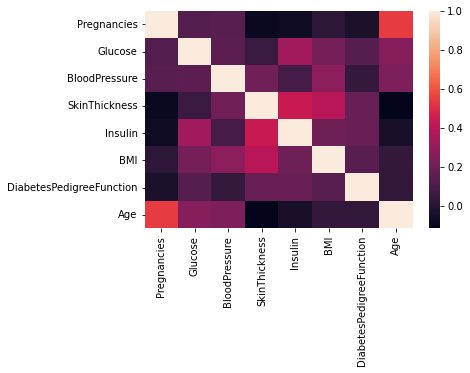

In [394]:
sns.heatmap(corr_df);

# Machine Learning Preparation

Pada tahap ini, kita akan menggunakan beberapa library yaitu:


1.   **StringIndexer**: ini digunakan agar algoritma machine learning dapat mengidentifikasi kolom data sebagai variabel kategorikal atau jika ingin mengonversi data teks menjadi data numerik dengan menjaga konteks kategorikal.
2.   **OneHotEncoder**: memetakan kolom indeks kategori ke kolom vektor biner, dengan paling banyak satu nilai per baris yang menunjukkan indeks kategori input.
3.   **VectorAssembler**: berguna untuk menggabungkan *raw features* menjadi satu vektor fitur, untuk melatih model ML seperti logistic regression dan decision tree.
4.   **StandardScaler**: mengubah set data baris Vektor, menormalisasi setiap fitur agar memiliki standar deviasi satuan dan/atau rata-rata sama dengan nol.
5.   **Pipeline**: pipeline merupakan urutan tahapan, dan setiap tahapan adalah *Transformer* atau *Estimator*. Tahapan ini dijalankan secara berurutan, dan input DataFrame ditransformasikan saat melewati setiap tahap tsb.

Tahap ini merupakan tahap persiapan data agar dapat diolah dan diproses ke tahap selanjutnya yaitu pengujian data lalu pembuatan model.

In [395]:
# import library yang dibutuhkan

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [396]:
categoricalColumns = ['age_udf']
numericalColumns = ['Pregnancies',
                              'Glucose',
                              'BloodPressure',
                              'SkinThickness',
                              'Insulin',
                              'BMI',
                              'DiabetesPedigreeFunction']
stages = []
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+'_index')
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"_class_vec"])
  stages += [stringIndexer, encoder]

label_string_indexer = StringIndexer(inputCol='HasDiabetes', outputCol='label')
stages += [label_string_indexer]
assemblerInputs = [c + '_class_vec' for c in categoricalColumns] + numericalColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vec_features')
stages += [assembler]
scaler = StandardScaler(inputCol='vec_features',outputCol='features')
stages += [scaler]

In [397]:
cols = df.columns
pipeline = Pipeline(stages=stages)
df_pipe = pipeline.fit(df).transform(df)
selectedCols = ['label','features'] + cols 
df2 = df_pipe.select(selectedCols)
df2.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- HasDiabetes: string (nullable = true)
 |-- age_udf: string (nullable = true)



# Pembagian Data Uji dan Data Latih

Data berjumlah 768 records data.

Data akan dibagi menjadi data latih dan data uji. Dimana data latih sebesar 80% dan data uji sebesar 20%.

In [398]:
train, test = df2.randomSplit([0.8, 0.2], seed=42)
print(f"Training Data Size: {train.count()}")
print(f"Test Data Size: {test.count()}")

Training Data Size: 645
Test Data Size: 123


In [399]:
train.groupby('HasDiabetes').count().show()

+-----------+-----+
|HasDiabetes|count|
+-----------+-----+
|         no|  426|
|        yes|  219|
+-----------+-----+



# Training Model

Model akan dilatih dengan algoritma *Logistic Regression*

In [400]:
from pyspark.ml.classification import LogisticRegression

In [401]:
lr = LogisticRegression(featuresCol='features',labelCol='label', maxIter=5)
model = lr.fit(train)
pred = model.transform(test)
pred.select('label','features', 'rawPrediction','prediction','probability').toPandas().head()

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.0778862096170094, 0.0, 0.0, 1.7806383732194...","[1.7429907939660518, -1.7429907939660518]",0.0,"[0.8510665535756853, 0.14893344642431472]"
1,0.0,"(2.0778862096170094, 0.0, 0.0, 0.0, 2.90873895...","[1.7757500436502376, -1.7757500436502376]",0.0,"[0.8551712886841937, 0.14482871131580632]"
2,0.0,"(2.0778862096170094, 0.0, 0.0, 0.0, 3.15895305...","[1.6908882842461948, -1.6908882842461948]",0.0,"[0.8443409421795658, 0.1556590578204342]"
3,0.0,"(2.0778862096170094, 0.0, 0.0, 0.0, 2.94001571...","[4.583572403090509, -4.583572403090509]",0.0,"[0.9898850310287187, 0.01011496897128128]"
4,0.0,"(0.0, 2.2134517648286796, 0.0, 2.0774114354226...","[4.391237966015179, -4.391237966015179]",0.0,"[0.9877661341261984, 0.012233865873801597]"


# Evaluasi Model

In [402]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [403]:
eval = BinaryClassificationEvaluator()
print(f"Test Area Under ROC: {eval.evaluate(pred)}")

Test Area Under ROC: 0.8309431880860446


# Akurasi Model

In [404]:
acc = pred.filter(pred.label == pred.prediction).count() / float(pred.count())
print(f"Accuracy: {acc}")

Accuracy: 0.7804878048780488
